## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
tfds.disable_progress_bar()

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10401042104589976671
xla_global_id: -1
]


In [4]:
tf.test.is_built_with_cuda()

True

## Prepare Dataset

In [3]:
ds_train = tf.keras.utils.image_dataset_from_directory("asl_alphabet_train", image_size=(200,200), seed=128, validation_split=0.2, subset="training")
ds_test = tf.keras.utils.image_dataset_from_directory("asl_alphabet_train", image_size=(200,200), seed=128, validation_split=0.2, subset="validation")

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


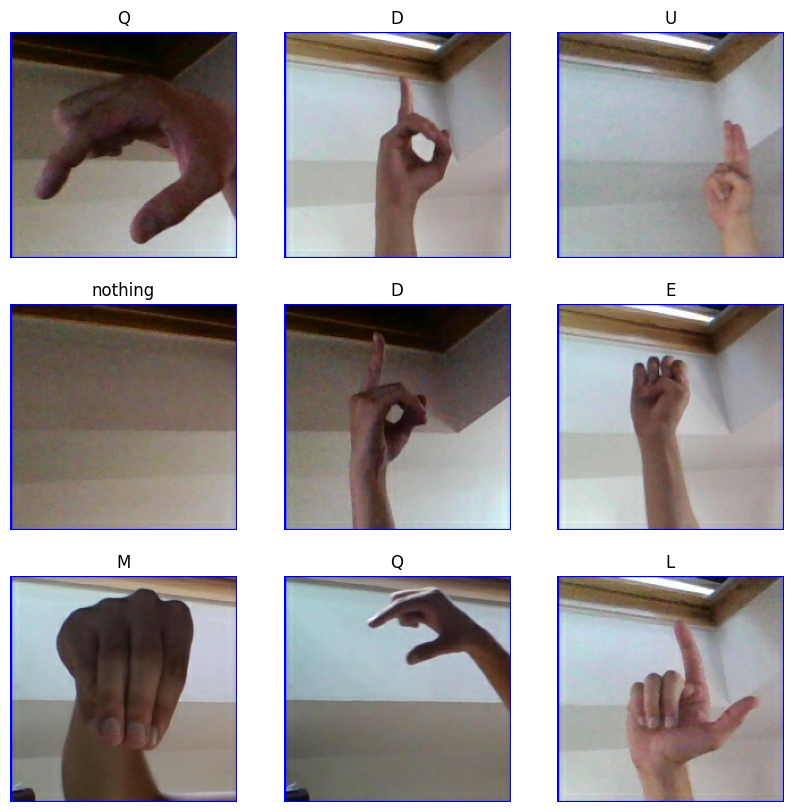

In [4]:
class_names = ds_train.class_names
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)
num_labels = len(class_names)

## Convolutional Neural Network

In [10]:
model = tf.keras.Sequential([
   tf.keras.layers.Rescaling(1./255),
   tf.keras.layers.AveragePooling2D(6,3, input_shape=(200,200,1)),
   tf.keras.layers.Conv2D(64, 3, activation='relu'),
   tf.keras.layers.Conv2D(32, 3, activation='relu'),
   tf.keras.layers.MaxPool2D(2,2),
   tf.keras.layers.Dropout(0.5),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(num_labels, activation='softmax')
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [6]:
history = model.fit(ds_train, validation_data=ds_test, epochs=5, batch_size=32)

Epoch 1/5
2175/2175 [==============================] - 569s 253ms/step - loss: 1.0774 - accuracy: 0.6733 - val_loss: 0.3072 - val_accuracy: 0.9037
Epoch 2/5
2175/2175 [==============================] - 481s 221ms/step - loss: 0.2986 - accuracy: 0.9007 - val_loss: 0.1975 - val_accuracy: 0.9432
Epoch 3/5
2175/2175 [==============================] - 471s 217ms/step - loss: 0.1870 - accuracy: 0.9365 - val_loss: 0.0732 - val_accuracy: 0.9772
Epoch 4/5
2175/2175 [==============================] - 456s 210ms/step - loss: 0.1334 - accuracy: 0.9536 - val_loss: 0.0624 - val_accuracy: 0.9796
Epoch 5/5
2175/2175 [==============================] - 457s 210ms/step - loss: 0.1109 - accuracy: 0.9623 - val_loss: 0.0536 - val_accuracy: 0.9831


In case we lose the history of this run, it took 40 minutes to fit the model with the default layers we have. Here is the data:

Epoch 1/5

2175/2175 [==============================] - 569s 253ms/step - loss: 1.0774 - accuracy: 0.6733 - val_loss: 0.3072 - val_accuracy: 0.9037

Epoch 2/5

2175/2175 [==============================] - 481s 221ms/step - loss: 0.2986 - accuracy: 0.9007 - val_loss: 0.1975 - val_accuracy: 0.9432

Epoch 3/5

2175/2175 [==============================] - 471s 217ms/step - loss: 0.1870 - accuracy: 0.9365 - val_loss: 0.0732 - val_accuracy: 0.9772

Epoch 4/5

2175/2175 [==============================] - 456s 210ms/step - loss: 0.1334 - accuracy: 0.9536 - val_loss: 0.0624 - val_accuracy: 0.9796

Epoch 5/5

2175/2175 [==============================] - 457s 210ms/step - loss: 0.1109 - accuracy: 0.9623 - val_loss: 0.0536 - val_accuracy: 0.9831

In [7]:
model.save("asl_trained_model")

INFO:tensorflow:Assets written to: asl_trained_model\assets


INFO:tensorflow:Assets written to: asl_trained_model\assets


Let's check out the summary of the model before we save it off so we can compare it.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 average_pooling2d (AverageP  (None, 65, 65, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0

In [7]:
saved_model = tf.keras.models.load_model('asl_trained_model')

# Check its architecture
saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 average_pooling2d (AverageP  (None, 65, 65, 3)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0

Looking to evaluate using this doc:

https://www.tensorflow.org/tutorials/keras/save_and_load

In [5]:
ds_val = tf.keras.utils.image_dataset_from_directory("asl_alphabet_test", image_size=(200,200), seed=128, )

Found 28 files belonging to 28 classes.


In [13]:
# Evaluate the restored model
loss, acc = saved_model.evaluate(ds_val, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(saved_model.predict(ds_val).shape)

1/1 - 0s - loss: 3.1103 - accuracy: 0.9286 - 66ms/epoch - 66ms/step
Restored model, accuracy: 92.86%
1/1 [==============================] - 0s 71ms/step
(28, 29)


In [9]:
saved_model.predict(ds_test)

544/544 [==============================] - 31s 57ms/step


array([[3.84525099e-17, 6.42273787e-22, 4.18394936e-22, ...,
        1.16759565e-20, 1.00000000e+00, 1.25677517e-13],
       [2.55495097e-17, 5.73135156e-25, 1.50758037e-25, ...,
        1.20913074e-18, 1.02943357e-19, 3.78049182e-13],
       [9.99952435e-01, 4.52070187e-11, 2.82039669e-10, ...,
        2.10870043e-17, 7.03916831e-16, 1.75853599e-23],
       ...,
       [1.15425980e-24, 1.10750742e-16, 5.78126167e-34, ...,
        5.15789828e-17, 9.15353348e-20, 8.60402537e-22],
       [1.27072045e-13, 4.58209669e-19, 5.36165253e-12, ...,
        1.37755638e-12, 7.30749882e-17, 1.07270370e-14],
       [4.19023838e-09, 1.01764845e-05, 2.09307135e-03, ...,
        1.51602013e-29, 5.47212898e-32, 8.78184934e-31]], dtype=float32)

## AlexNet

Reference: https://d2l.ai/chapter_convolutional-modern/alexnet.html

Preprocess Images: https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

In [7]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 200x200 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

In [7]:
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

: 

: 

In [7]:
ds_train_sz = tf.data.experimental.cardinality(ds_train).numpy()
ds_test_sz = tf.data.experimental.cardinality(ds_test).numpy()
ds_train = (ds_train.map(process_images)
                    .shuffle(buffer_size=ds_train_sz)
                    .batch(batch_size=32, drop_remainder=True))
ds_test = (ds_test.map(process_images)
                  .shuffle(buffer_size=ds_test_sz)
                  .batch(batch_size=32, drop_remainder=True))

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

lr = tf.keras.optimizers.schedules.ExponentialDecay(
    0.1, 10000, 0.90, staircase=False,
)

# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=lr,
#     weight_decay=0.0005
# )
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)
model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
history = model.fit(ds_train, validation_data=ds_test, epochs=5, batch_size=128)

Epoch 1/5


ValueError: in user code:

    File "c:\Python379\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Python379\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Python379\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Python379\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Python379\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Python379\lib\site-packages\keras\engine\input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 227, 227, 3), found shape=(32, None, 227, 227, 3)


Epoch 1/75
2175/2175 [==============================] - 1895s 863ms/step - loss: 15.3194 - accuracy: 0.0340 - val_loss: 15.2303 - val_accuracy: 0.0366
Epoch 2/75
2175/2175 [==============================] - 1882s 865ms/step - loss: 15.3170 - accuracy: 0.0340 - val_loss: 15.2303 - val_accuracy: 0.0366
Epoch 3/75
2175/2175 [==============================] - 1723s 792ms/step - loss: 15.3168 - accuracy: 0.0340 - val_loss: 15.2303 - val_accuracy: 0.0366
Epoch 4/75
2175/2175 [==============================] - 1654s 761ms/step - loss: 15.4936 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 5/75
2175/2175 [==============================] - 1647s 757ms/step - loss: 15.5751 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 6/75
2175/2175 [==============================] - 1660s 763ms/step - loss: 15.5825 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 7/75
2175/2175 [==============================] - 1659s 763ms/step - loss: 15.5747 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 8/75
2175/2175 [==============================] - 1691s 777ms/step - loss: 15.5780 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 9/75
2175/2175 [==============================] - 1668s 767ms/step - loss: 15.5767 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 10/75
2175/2175 [==============================] - 1686s 775ms/step - loss: 15.5831 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 11/75
2175/2175 [==============================] - 1665s 765ms/step - loss: 15.5829 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 12/75
2175/2175 [==============================] - 1668s 767ms/step - loss: 15.5773 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 13/75
2175/2175 [==============================] - 1721s 791ms/step - loss: 15.5844 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 14/75
2175/2175 [==============================] - 1726s 794ms/step - loss: 15.5791 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 15/75
2175/2175 [==============================] - 1731s 796ms/step - loss: 15.5805 - accuracy: 0.0340 - val_loss: 15.5030 - val_accuracy: 0.0366
Epoch 16/75
 360/2175 [===>..........................] - ETA: 22:33 - loss: 15.5777 - accuracy: 0.0345

In [ ]:
model.save("Alex_Net_asl_trained_model")

INFO:tensorflow:Assets written to: Alex_Net_asl_trained_model\assets


INFO:tensorflow:Assets written to: Alex_Net_asl_trained_model\assets


In [17]:
saved_model = tf.keras.models.load_model('Alex_Net_asl_trained_model')

# Check its architecture
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 96)        34944     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 384)       885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 384)      

In [18]:
# Evaluate the restored model
loss, acc = saved_model.evaluate(ds_val, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(saved_model.predict(ds_val).shape)

1/1 - 0s - loss: 15.4898 - accuracy: 0.0357 - 252ms/epoch - 252ms/step
Restored model, accuracy:  3.57%
1/1 [==============================] - 0s 194ms/step
(28, 29)


## ResNet

Reference: https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/

In [12]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [13]:
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    0.1, 13050, 0.94, staircase=False,
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
    weight_decay=0.0005
)
model = ResNet34((200,200,3), num_labels)
model.compile(optimizer=optimizer,
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
history = model.fit(ds_train, validation_data=ds_test, epochs=3, batch_size=32)

Epoch 1/3
2175/2175 [==============================] - 7477s 3s/step - loss: 0.7883 - accuracy: 0.7527 - val_loss: 1.8311 - val_accuracy: 0.6761
Epoch 2/3
2175/2175 [==============================] - 7539s 3s/step - loss: 0.0899 - accuracy: 0.9706 - val_loss: 2.9892 - val_accuracy: 0.4700
Epoch 3/3
2175/2175 [==============================] - 7802s 4s/step - loss: 0.0557 - accuracy: 0.9825 - val_loss: 0.3265 - val_accuracy: 0.9063


Epoch 1/3

2175/2175 [==============================] - 7477s 3s/step - loss: 0.7883 - accuracy: 0.7527 - val_loss: 1.8311 - val_accuracy: 0.6761

Epoch 2/3

2175/2175 [==============================] - 7539s 3s/step - loss: 0.0899 - accuracy: 0.9706 - val_loss: 2.9892 - val_accuracy: 0.4700

Epoch 3/3

2175/2175 [==============================] - 7802s 4s/step - loss: 0.0557 - accuracy: 0.9825 - val_loss: 0.3265 - val_accuracy: 0.9063

In [22]:
model.save("Res_Net_asl_trained_model")

INFO:tensorflow:Assets written to: Res_Net_asl_trained_model\assets


INFO:tensorflow:Assets written to: Res_Net_asl_trained_model\assets


In [14]:
ds_val = tf.keras.utils.image_dataset_from_directory("asl_alphabet_test", image_size=(200,200), seed=128, )

Found 28 files belonging to 28 classes.


In [15]:
saved_model = tf.keras.models.load_model('Res_Net_asl_trained_model')

# Check its architecture
saved_model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 103, 103, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [16]:
# Evaluate the restored model
loss, acc = saved_model.evaluate(ds_val, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(saved_model.predict(ds_val).shape)

1/1 - 1s - loss: 1.2533 - accuracy: 0.8929 - 1s/epoch - 1s/step
Restored model, accuracy: 89.29%
1/1 [==============================] - 1s 1s/step
(28, 29)
